<a href="https://colab.research.google.com/github/Carhuacusma/CC61_PDI_Trabajo_Final/blob/main/CC61_PDI_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CC61: Procesamiento de Imágenes
# **Trabajo Final**

Alumnos:
* Galván Díaz, Joaquín Adrían : u201810A.
* Moreno Carhuacusma, Dante Brandon : u201818067

## Objetivos

* Distinguir una partitura musical en una imagen
* Extraer el sonido que correspone a los símbolos en la partitura
* Determinar el mejor acercamiento con técnicas de procesamiento de imágenes al problema

### Estado del Arte

Las partituras musicales cuentan con una simbología específica. Para poder definir los objetivos técnicos del trabajo, primero debemos familiarizarnos con la escritura musical. 

![Claves y notas](https://guitarrasinlimites.b-cdn.net/wp-content/uploads/2018/03/notas-musicales-claves-m%C3%A1s-usadas.jpg)

Buscamos entonces identificar cuál de los tres tipos símbolos está escrito primero en el pentagrama: Clave de Sol, Clave de Fa, o Clave de Do.

Además, es importante definir la ubicación de estos símbolos en el pentagrama para saber qué notas corresponden a los espacios entre y en las líneas.

A USAR: https://adrifersa.com/teoria-musical/la-clave-musical/ 

## Planteamiento (Borrador porque no estoy seguro del formato xd)

### Preprocesamiento

Todas las imágenes cargadas pasan por un método para "rectificarlas", asumiendo que podrían ser fotos de partituras impresas, desde diversos ángulos.

1. Si no está en escala de grises, convertir a escala de grises.
2. Blur: Aplica filtro bilateral gaussiano sobre la imagen en escala de grises para facilitar el proceso de *edge detection*.
3. Edge Detection: Aplica el filtro Canny a la imagen resultante.
4. Código de la Cadena: Aplica la función findCountours de OpenCV para la detección de contornos con el código de la cadena. Retorna un arreglo de contornos con los puntos que componen a cada uno.
5. Ordena el arreglo de contornos obtenido según el área.

![Imagen de una hoja impresa](https://raw.githubusercontent.com/Carhuacusma/CC61_PDI_Trabajo_Final/main/Data/Fotos/mary_hoja.jpg)

Para extraer la posible hoja de la imagen y rectificarla, considera los siguientes parámetros
- $contornos$: Arreglo del 15% de contornos con mayor área, los que podrían ser una hoja.
- $areaTotal$: Área de la imagen filtrada.
- $umbralHoja$: Un umbral para determinar cuál debe ser la proporción hoja/imagen mínima y así evitar amplificar cuadrados pequeños en imágenes de partituras ideales.

Entonces
* Por cada *contorno* $C$ en el arreglo $contornos$:
> * $approx \gets$ Polígono Aproximado del contorno $C$, con método de OpenCV
> * Si el polígono aproximado $approx$ es de 4 esquinas:
>> - $auxArea \leftarrow$ Área de $approx$ 
>> - Si $\frac{auxArea}{areaTotal} > umbralHoja:$
>>> - $candidatoHoja \gets approx$
>>> - *break for*

En el caso en que $candidatoHoja$ no tenga valor, se asume que la imagen ingresada es una imagen ideal, y no se realiza la transformación geométrica para corregir la perspectiva y considerar únicamente la región dentro de la hoja impresa.

### Extracción de lineas: Transformada de Hough

Se aplica la transformada de Hough para extraer las líneas en la partitura, aunque no se puede estar seguro de que la orientación sea la correcta.

El método $HoughLinesP$ de cv2 retorna un arreglo donde cada línea se representa por las coordenadas de sus puntos extremos.
Este arreglo pasa por la función $hacerDFdeLineas$, que como su nombre describe, busca crear un DataFrame de las líneas, con los atributos: Punto 1, Punto 2, Longitud, Ángulo.

Punto 1 se define como el punto extremo de la línea más cercano al origen de coordenadas. La longitud es la distancia euclidiana entre estos puntos extremos, y el ángulo es el arco tangente de la pendiente entre estas dos líneas.

Con los ángulos de cada línea se puede definir la orientación para mejorar la orientación de la imagen. Sin embargo, el preprocesamiento no es perfecto.
Las líneas detectadas pueden no ser todas del pentagrama; mientras que otras pueden ser solo un segmento de una línea cortada por una nota en medio. Además, el ángulo calculado puede no ser el mismo entre las líneas del pentagrama

Para considerar los posibles errores del cálculo de ángulos, se dividió el círculo trigonométrico en 8 secciones. De estos, se nombran 4 sectores, representados gráficamente en la Figura 2:

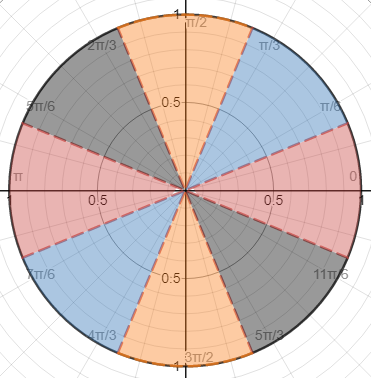

*Figura 2: Círculo trigonométrico divido en 8 secciones*

Donde:
* En el sector rojo, o primer sector, de $-\frac{\pi}{8}$ rad a $\frac{\pi}{8}$ rad se ubicarían líneas horizontales, a pesar de que el caso perfecto sean los $0$ rad.
* El segundo sector, de celeste, ubica a las líneas diagonales, que son un caso que se espera sea raro. Se descartan como posibles líneas del pentagrama, a no ser que no exista otro candidato, forzando otra transformación geométrica a la imagen para rectificar. Está en el rango de $\frac{3\pi}{8}$ rad a $\frac{5\pi}{8}$
* El tercer sector, de naranja, ubica líneas verticales. Si las líneas del pentagrama están en este sector, simplemente se necesita rotar en 90° a la imagen. Está en el rango de $\frac{5\pi}{8}$ rad a $\frac{7\pi}{8}$
* El cuarto sector, de negro, es el otro sector con líneas diagonales que podría forzar una transformación geométrica. Está en el rango de $\frac{7\pi}{8}$ rad a $\frac{9\pi}{8}$

Debido al funcionamiento del método *arctan()* de *numpy*, los resultados estarán en el primer y cuarto cuadrante convencional del círculo trigonométrico. Sin embargo, para evitar complicaciones en la diferencia de ángulos, se convertirán todos los resultados al dominio $-\frac{\pi}{8}$ a $\frac{9\pi}{8}$

## Desarrollo

### Importación de librerías

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from skimage import io, morphology
from google.colab.patches import cv2_imshow
#import musicalbeeps

In [ ]:
#No da error en colab pero no funciona el import {simbolo de exclamcion} pip install scikits.audiolab

In [ ]:
#from scikits.audiolab import play

### Cargar Imágenes

#### Imágenes de claves musicales

In [2]:
repo = "https://raw.githubusercontent.com/Carhuacusma/CC61_PDI_Trabajo_Final/main/Data/"

In [110]:
arrClaves_Grises = [0 for _ in range(3)]
arrClaves_Grises[0] = cv2.cvtColor(io.imread("%s%s"%(repo,"Claves/sol.jpg")),cv2.COLOR_RGB2GRAY)
arrClaves_Grises[1] = cv2.cvtColor(io.imread("%s%s"%(repo,"Claves/fa.jpg")),cv2.COLOR_RGB2GRAY)
arrClaves_Grises[2] = cv2.cvtColor(io.imread("%s%s"%(repo,"Claves/do.jpg")),cv2.COLOR_RGB2GRAY)
arrNombresClaves = ["sol", "fa", "do"]

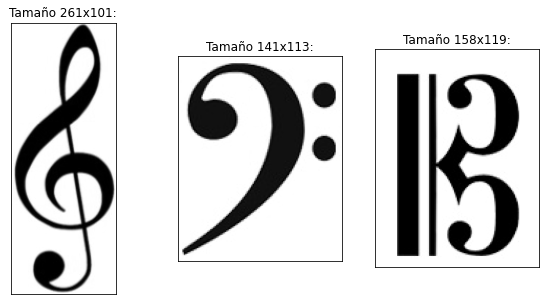

In [4]:
#Por ahora no se usa porque no encontré una imagen con todas las notas musicales con buena calidad
#(en la anterior se pixeleaba mucho, so that, esqueleto necesita thic)
def graficarArr(arrIm):
  n = len(arrIm)
  fig, ax = plt.subplots(1, n, figsize=(10,5), subplot_kw=dict(xticks=[],yticks=[]))
  for i in range(n):
    titulo = "Tamaño %sx%s:"%(arrIm[i].shape[0],arrIm[i].shape[1])
    ax[i].set_title(titulo);
    ax[i].imshow(arrIm[i],cmap='gray')
graficarArr(arrClaves_Grises)

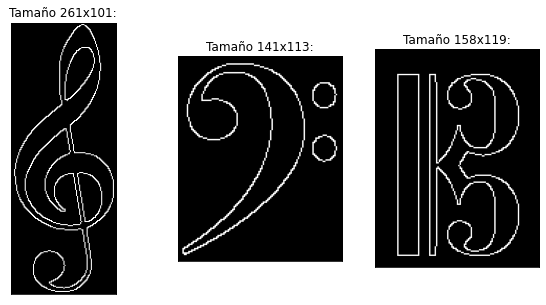

In [5]:
def filtrarArrIm(arrIm, funcion):
  arrImF = []
  for imagen in arrIm:
    imFiltrada = funcion(imagen)
    arrImF.append(imFiltrada)
  return arrImF
def aux(imagen):
  return cv2.Canny(imagen,50,100)
arrClaves_Canny = filtrarArrIm(arrClaves_Grises, aux)
graficarArr(arrClaves_Canny)

#### Imágenes de Prueba

In [6]:
ruta = "Fotos/mary_hoja.jpg"
imHoja = io.imread("%s%s"%(repo,ruta))
print(type(imHoja))

<class 'numpy.ndarray'>


In [7]:
ruta = "Ideal/mary_had_a_little_lamb.jpg"
imIdeal = io.imread("%s%s"%(repo,ruta))
print(type(imIdeal))

<class 'numpy.ndarray'>


### Preprocesamiento

#### Funciones auxiliares

In [65]:
def lineP_a_Puntos(linea): #Return P1, P2, Long, Ang
  l = linea[0]
  p1 = np.array([l[0],l[1]])
  p2 = np.array([l[2],l[3]])
  sp1 = p1[0] + p1[1]
  sp2 = p2[0] + p2[1]
  if sp2 < sp1:
    return p2, p1
  return p1, p2 #.....p1: Más cerca al (0,0)

#Para poder ser usada como key en sorted
def distEuclidLineP(lineaP):
  p1, p2 = lineP_a_Puntos(lineaP)
  return np.linalg.norm(p2-p1)

def corregirAnguloSectores(angulo, limite):
  if angulo < limite:
    angulo += np.pi
  return round(angulo*100) / 100

#Ejemplo:
print(distEuclidLineP([[0,0,pow(2,0.5),pow(2,0.5)]]))

def valoresLineP(linea, limiteInfAng= -(np.pi/8)):
  p1, p2 = lineP_a_Puntos(linea)
  dx = p2[0] - p1[0]
  dy = p2[1] - p1[1]
  theta = np.pi / 2
  if dx != 0:
    theta = np.arctan(dy/dx)
  theta = corregirAnguloSectores(theta, limiteInfAng)
  tam = distEuclidLineP(linea)
  return [p1,p2,tam,theta]

def escalar(imagen, ratio):
  w = int(imagen.shape[1] * ratio)
  h = int(imagen.shape[0] * ratio)
  return cv2.resize(imagen, (w,h), interpolation = cv2.INTER_AREA)

#Ejemplo:
_,_,_,aux = valoresLineP([[0,0,pow(2,0.5),pow(2,0.5)]])
print(valoresLineP([[0,0,pow(2,0.5),pow(2,0.5)]],0))
print(aux)

2.0
[array([0, 0]), array([1.41421356, 1.41421356]), 2.0, 0.79]
0.79


#### Extraer esqueleto de las Claves musicales (Sol, Fa, Do)

In [180]:
# Extraer Contornos de Claves / Canny {run: "auto"}
#lim1 = 45 #@param {type:"slider", min:5, max:100, step:1}
#lim2 = 210 #@param {type:"slider", min:105, max:250, step:1}
#def aux(imagen):
#  return cv2.Canny(imagen,lim1,lim2)
#arrClaves_Canny = filtrarArrIm(arrClaves_Grises,aux)
#arrClaves_Contornos = [0 for _ in range(3)]
#for i in range(3):
#  contours, _ = cv2.findContours(arrClaves_Canny[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#  aux = cv2.cvtColor(arrClaves_Grises[i].copy(),cv2.COLOR_GRAY2BGR)
#  j = 0
#  for contorno in contours:
#    cv2.drawContours(aux, [contorno], -1, (j,j*3,255-j*2), 3)
#    j += 1
#  arrClaves_Contornos[i] = contours
#  cv2_imshow(aux)

Hasta ahora tenemos:
* $arrClaves\_Grises:$ Arreglo de las imágenes de las claves musicales en escala de grises
* $arrClaves\_Canny:$ Arreglo de las imágenes de las claves filtradas con Canny
* $arrClaves\_Contornos:$ Donde $arrClaves\_Contornos[i]$ es el arreglo de $contours$ (resulta del Código de la Cadena).

Recordando que un contorno dentro de $contours$ está en formato:
 $contour \leftarrow$ [ [ $Punto 1$ ], [ [$ Punto 2 $] ], ... ] 

In [32]:
def arrROIsDeContours(contours): #Recibe arreglo de contornos en el formato contours
  ROIs = []
  for contour in contours:
    x,y,w,h = cv2.boundingRect(contour) #Rectángulo envolvente: posición en x, posición en y, ancho, alto
    ROIs.append((x,y,w,h))
    #cv2_imshow(imagen[y:y+h,x:x+w])
  return ROIs #Regresa un arreglo de ROIs, uno por cada contorno analizado

In [ ]:
#arrClaves_ROIs = [0 for _ in range(3)]
#for i in range(3):
#  contornos = arrClaves_Contornos[i]
#  arrRoi = arrROIsDeContours(contornos,arrClaves_Grises[i])
#  arrClaves_ROIs[i] = arrRoi

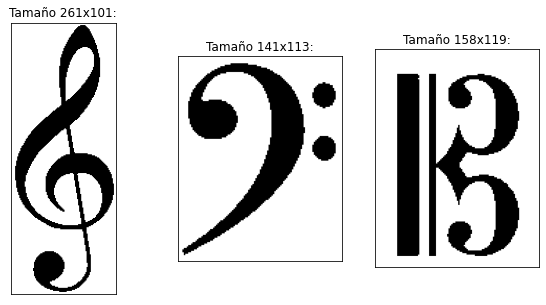

In [9]:
def aux(imagenGris):
  _, binarized = cv2.threshold(imagenGris, 120, 255, cv2.THRESH_BINARY)
  return binarized
arrClaves_Binarized = filtrarArrIm(arrClaves_Grises,aux)
graficarArr(arrClaves_Binarized)

In [ ]:
#Se usaba cuando había arreglo de ROIs por imagen, pero ya el repositorio guarda imágenes pequeñas
#def esqueletizarROIS(rois,binaria):
#  for x, y, w, h in rois:
#    ROI=255-binaria[y:y+h, x:x+w]
#    ROI[ROI==255]=1
#    print(f'valores unicos: {np.unique(ROI)}')
#    skeleton = morphology.skeletonize(ROI)*255
#    cv2_imshow(binaria[y:y+h, x:x+w]+skeleton)
#esqueletizarROIS(arrClaves_ROIs[0],arrClaves_Binarized[0])

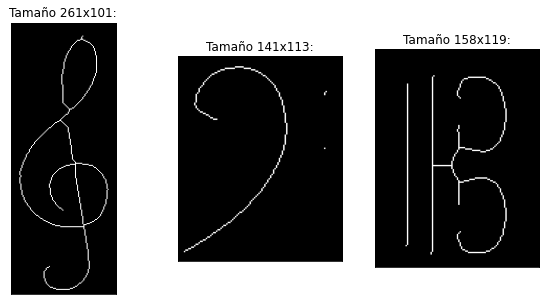

In [74]:
def esqueletizar(imagenBinarizada):
  (x,y,w,h) = [0,0,imagenBinarizada.shape[1],imagenBinarizada.shape[0]]
  ROI = 255 - imagenBinarizada #Se asume completa: [y:y+h, x:x+w]
  ROI[ROI==255]=1
  skeleton = np.array(morphology.skeletonize(ROI)*255,dtype=np.uint8)
  #cv2_imshow(imagenBinarizada+skeleton)
  return skeleton
arrEsqueletos = filtrarArrIm(arrClaves_Binarized,esqueletizar)
graficarArr(arrEsqueletos)

In [75]:
arrEsqueletos[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Warping

In [11]:
def ordenarEsquinas(pts):
    rect = np.zeros((4, 2), dtype = "float32") # ..| Rectángulo de 0s para ser como un canvas
    oAux = pts.sum(axis = 1) #.....................| Arreglo de 4 resultados : oAux[i] = pts[i][0] + pts[i][1]
    rect[0] = pts[np.argmin(oAux)] # La esquina superior izquierda tiene la suma más pequeña
    rect[2] = pts[np.argmax(oAux)] # La esquina inferior derecha tiene la mayor suma
    oAux = np.diff(pts, axis = 1)  # ..............| Arreglo de 4 resultados : oAux[i] = |(pts[i][0] - pts[i][1])|
    rect[1] = pts[np.argmin(oAux)] # La esquina superior derecha tiene la mínima diferencia (X mayor)
    rect[3] = pts[np.argmax(oAux)] # La esquina inferior izquierda maxima diferencia
    return rect

In [42]:
def warping(topL, topR, botR, botL):
    widthA = np.sqrt(((botR[0] - botL[0]) ** 2) + ((botR[1] - botL[1]) ** 2)) #.... | Distancia euclidiana
    widthB = np.sqrt(((topR[0] - topL[0]) ** 2) + ((topR[1] - topL[1]) ** 2)) #.... | ""
    heightA = np.sqrt(((topR[0] - botR[0]) ** 2) + ((topR[1] - botR[1]) ** 2)) #... | ""
    heightB = np.sqrt(((topL[0] - botL[0]) ** 2) + ((topL[1] - botL[1]) ** 2)) #... | ""
    maxWidth = max(int(widthA), int(widthB)) #......... | El anchos máximo se usa para la nueva imagen
    maxHeight = max(int(heightA), int(heightB)) #...... | El alto máximo se usa para la nueva imagen
    #.................................................. | dst: Puntos de destino, imagen "recta"
    dst = np.array([[0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype = "float32")
    def funcWarp(imagen):
      M = cv2.getPerspectiveTransform(np.array([topL,topR,botR,botL]), dst) #......... Matriz de transformación
      return cv2.warpPerspective(imagen, M, (maxWidth, maxHeight)) #.................. Aplicar la matriz para obtener la imagen nueva
    return funcWarp

In [43]:
def enCasoHoja(imagen,contornos,umbralHoja = 0.5):
    contornos = contornos[:int(0.15*len(contornos))] #........ 1. Extrae el 15 % de contornos con mayor área
    candHoja = []
    auxArea = 0
    for c in contornos: #..................................... 2. Por cada C que pertenece a Contornos:
        perimetro = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * perimetro, True) #......2.1. Disminuir el número de lados de C (Polígono Aproximado)
        if len(approx) == 4: #.......................................2.2. Si el polígono aproximado es de 4 lados:
            auxArea = cv2.contourArea(approx) #................................ Considera el Área del "candidato a hoja"
            if auxArea/((imagen.shape[0])*(imagen.shape[1])) > umbralHoja: #... Si la proporción de las áreas candidato/imagen supera el umbral:
                candHoja = approx #................................................... "Candidato" es la hoja impresa
                break
    if len(candHoja) == 0:
        print("Imagen sin 4 esquinas de hoja:")
        def funcion(imagenInput):
          return imagenInput
        return funcion
    else:
        puntos = candHoja.reshape(4, 2) #... Para manejar mejor los puntos
        rect = ordenarEsquinas(puntos) #.... Ordena las esquinas a formato:
        (tl, tr, br, bl) = rect #........... Sentido Horario, Esquinas: Superior Izquierda, Superior Derecha,...
        print("Foto con esquinas")
        return warping(topL=tl,topR=tr,botR=br,botL=bl)

In [44]:
def rectificar_parte_1(imagen, umbralHoja = 0.5):
    if len(imagen.shape) != 2:
        imagen = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY) #....................| 1. Asegura Escala de Grises, 
    imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30) # .| 2. Blur, 
    im_canny = cv2.Canny(imagen,50,205) #...................................| 3. Edge Detector: Canny >> Imagen con bordes
    #............. Extraer la hoja impresa de la foto:
    contornos, _ = cv2.findContours(im_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #...| 1. Extrae "Contornos" con Cadena (findContours) 
    contornos = sorted(contornos, key = cv2.contourArea, reverse = True) #..............| 2. Ordenar "Contornos" por Área
    funcionT = enCasoHoja(im_canny,contornos,umbralHoja) #...............................| 3. Imagen de la hoja impresa 
    #............. Rectificar la orientación
    imagenF = funcionT(im_canny)
    imagen = funcionT(imagen) 
    return imagenF, imagen

(1600, 900, 3)


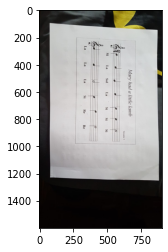

In [45]:
plt.imshow(imHoja)
print(imHoja.shape)

Foto con esquinas


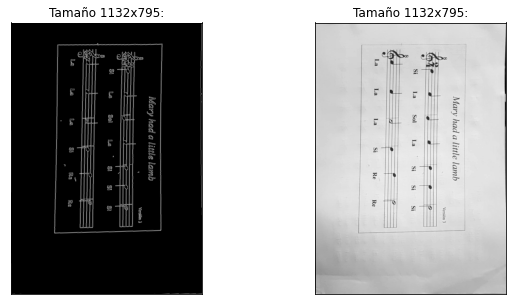

In [49]:
r_imCanny, r_imHoja = rectificar_parte_1(imHoja) # Hoja impresa (con filtro Canny)
#print(r_imHoja.shape)
graficarArr([r_imCanny, r_imHoja])

#### Métodos de orientación

In [17]:
def hacerDFdeLineas(lineas):
    if lineas is None:
        print("No hay líneas")
        return None
    dfLineas = []
    arrLineas = []
    for linea in lineas:
        dfLineas.append(valoresLineP(linea))
        #arrLineas.append( Linea([l[0],l[1]], [l[2],l[3]]))
    return pd.DataFrame(data=dfLineas,columns=["Punto 1", "Punto 2", "Longitud", "Angulo"]) #, arrLineas

In [51]:
def orientaSegunLineas(imCanny, imagen):
  linesP = cv2.HoughLinesP(imCanny, 1, np.pi / 180, 50, None, 50, 10)
  if linesP is None:
    print("No detectó líneas")
    return imCanny
  lineas = sorted(linesP,key=distEuclidLineP,reverse=True) # Ordena las líneas de la más grande a la más pequeña
  lineas = lineas[:int(len(lineas)*0.20)] # El 20% Superior
  arrAng = []
  for linea in lineas:
    _,_,_,angulo = valoresLineP(linea)
    arrAng.append(angulo)
  angulo = stats.mode(arrAng)[0][0] #  mode[0] = [angulo], por eso [0][0]
  #................................... Problema: Dos valores de moda
  if abs(angulo - (np.pi / 2)) < 0.4:
    print("Rota 90° horario")
    return cv2.rotate(imCanny, cv2.ROTATE_90_COUNTERCLOCKWISE), cv2.rotate(imagen, cv2.ROTATE_90_COUNTERCLOCKWISE)
  #TODO : Agregar Caso de líneas no 0 o pi/2, sino diagonales
  print("No se hicieron cambios")
  return imCanny, imagen

Rota 90° horario


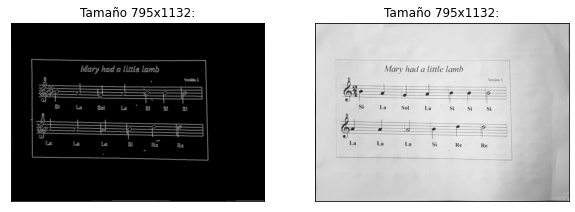

In [52]:
r_imCanny,r_imHoja = orientaSegunLineas(r_imCanny,r_imHoja)
graficarArr([r_imCanny,r_imHoja])

In [167]:
def compararImMatch(imagen,im2_t,umbral=0.5):
  res = cv2.matchTemplate(imagen,im2_t,cv2.TM_CCOEFF_NORMED)
  r = np.max(res)
  #print(r)
  if r > umbral:
    return True, r
  return False, r

In [151]:
A = np.array([[255,255],
              [255,255]],dtype=np.uint8)
B = np.array([[0,0,3,0,0,5,4],
              [0,0,3,255,255,5,4],
              [1,0,2,255,255,5,4]], dtype=np.uint8)
v, aux = compararImMatch(B,A)
if v:
  print(np.array(aux,dtype=np.uint8))

1


In [170]:
def atticus(imagenCanny, imagenGris,umbral): #No se me ocurren nombres y estaba escuchando la ost de the social network xd
  m, n = r_imCanny.shape
  qSuperior_C = imagenCanny[:m//2,:n//2] #.... | Cuarto superior izquierdo de la imagen en Canny
  qSuperior_G = imagenGris[:m//2,:n//2] #..... | " " " ................................ en Gris
  contours, _ = cv2.findContours(qSuperior_C, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  arrROIsQ = arrROIsDeContours(contours) #.... | Arreglo de ROIs en la porción cuarto superior
  #En estas ROI buscamos una Clave Musical
  for ROI in arrROIsQ:
    x,y,w,h = ROI
    imROI = qSuperior_G[y:y+h,x:x+w] #Gris porque usará MatchTemplate
    if imROI.shape[0] < 15:
      continue #................. Descartamos ROIs muy pequeñas
    for i in range(3):
      imClave = arrClaves_Grises[i]
      ratio = round(imROI.shape[0] / imClave.shape[0], 1)
      imTemp = escalar(imClave, ratio) #... Imagen Template: Clave Musical escalada para encajar
      if imROI.shape[0] < imTemp.shape[0] or imROI.shape[1] < imTemp.shape[1]:
        continue
      else:
        match, r = compararImMatch(imROI,imTemp,umbral)
        if match:
          cv2_imshow(imROI)
          print("Es :", arrNombresClaves[i])
          print("De aprox size:", imTemp.shape)
          return i, x, y,imTemp.shape
  return -1, 0, 0, (0,0)

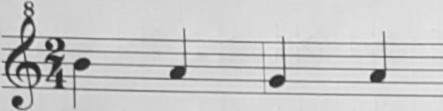

Es : sol
De aprox size: (104, 40)


(0, 123, 244, (104, 40))

In [171]:
atticus(r_imCanny,r_imHoja,0.575)

In [174]:
def rectificarClave(imCanny, imGris, umbral):
  (i, posX, posY, shapeClave) = atticus(imCanny,imGris,umbral)
  if i == -1:
    imagenCanny = cv2.rotate(imCanny, cv2.ROTATE_180)
    imagenGris = cv2.rotate(imagen, cv2.ROTATE_180)
    (i, posX, posY, shapeClave) = atticus(imCanny,imGris,umbral)
  if i == -1:
    print("PROBLEMA")
  return imCanny,imGris,i, posX, posY, shapeClave

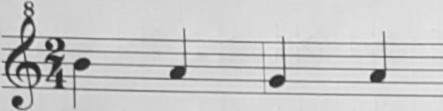

Es : sol
De aprox size: (104, 40)


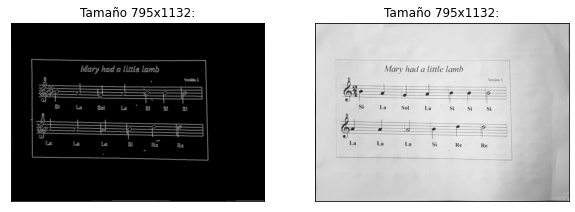

In [176]:
r_imCanny, r_imHoja, idClave, posX, posY, shapeClave =rectificarClave(r_imCanny,r_imHoja,0.57)
graficarArr([r_imCanny, r_imHoja])

### Líneas

In [ ]:
#Si definimos "mayor" como el punto más alejado del centro de coordenadas
def p1Mayor_p2(punto1, punto2):
  s1 = punto1[0] + punto1[1]
  s2 = punto2[0] + punto2[1]
  return s1 > s2

Justificación para la computación de algunas funciones:

"Línea", representa a un *segmento* (no es una recta infinita, sino con un punto inicial y final) hallado por HoughLinesP; se compone de:
* $punto 1$: Arreglo que representa las coordenadas del punto de la línea más **cercano** al centro de coordenadas.
* $punto 2$: Arreglo que representa las coordenadas del punto de la línea más **alejado** del centro de coordenadas.
* $longitud$: Distancia euclidiana entre $punto 1$ y $punto 2$. Representa la longitud del segmento.
* $angulo$: Ángulo en radianes que forma la línea.

In [ ]:
class Linea:
  def __init__(self, punto_1, punto_2):
    if p1Mayor_p2(punto_1, punto_2):
      aux = punto_1
      punto_1 = punto_2
      punto_2 = aux
    self.punto1 = punto_1
    self.punto2 = punto_2
    dx = punto_2[0] - punto_1[0]
    dy = punto_2[1] - punto_1[1]
    theta = np.pi / 2 #......................... Línea vertical, (dx = 0)
    if dx != 0: #............................... para evitar la división entre 0
      theta = np.arctan(dy/dx) #................ >> Asigna el angulo que corresponde.
    self.angulo = corregirAnguloSectores(theta,limite = -(np.pi/8))
    tam = pow((dx ** 2) + (dy ** 2), 0.5) #..... Distancia euclidiana para el tamaño
    self.longitud = round(tam,2) #.............. Redondea la distancia a dos decimales
  
  def __str__(self):
    res  = "Punto 1 : %s\nPunto2 : %s\n"%(self.punto1, self.punto2)
    res += "Longitud: %s\n"%self.longitud
    res += "Angulo: %s"%self.angulo
    return res

  def m(self): # float: Pendiente de la recta
    dx = self.punto2[0] - self.punto1[0]
    dy = self.punto2[1] - self.punto1[1]
    if dx == 0:
      return np.inf
    return round(dy/dx, 2)
  
  def eDomRan(self, val, eje): # bool: Pertenece al Dominio / Rango (según el valor de "eje")
    return val >= min(self.punto1[eje],self.punto2[eje]) and val <= max(self.punto1[eje],self.punto2[eje])

  def convertirAFuncion(self): # (aux, Funcion) | aux: bool (True: común // False: línea vertical) , Funcion: y(x); o x(y) si m = inf
    pend = self.m()
    if pend == np.inf:
      print("Funcion de linea vertical")
      def x(y):
        if not self.eDomRan(y,1):
          print("Valor de \'y\' fuera del dominio")
          return None
        return self.punto1[0]
      return False, x
    def y(x):
      if not self.eDomRan(x,0):
        print("Fuera del Dominio")
        return None
      return pend*x + (self.punto2[1] - pend*(self.punto2[0]))
    print(type(y))
    return True, y

  def ax_by_c(self): #...................................... | Explicación:
    if self.m() == np.inf: # Vertical ...................... | y - y1 = m*(x - x1)..... Queremos A*x + B*y = C
      return [1,0,self.punto1] #............................ | y - y1 = m*(x) - m*(x1)
    c = self.punto1[1] - self.m() * self.punto1[0] #......>> (-m)*x + (1)y = (y1 - m*x1) 
    return [-1*m,1,c] #...................................>> A = -m; B = 1; C = y1 - m * x1
  
  def puntoDentroRecEnvolvente(punto): #bool: si un Punto está dentro del Rectángulo Envolvente
    if self.eDomRan(punto[0],0) and self.eDomRan(punto[1],1):
       return True
    return False

  def intersectaROI(arrPuntos): #bool: si la línea corta con una región rectangular
    (topL, topR, botR, botL) = arrPuntos #Top Left, topRight, bottom Right, bottom Left
    if not self.puntoDentroRecEnvolvente(topL) or self.puntoDentroRecEnvolvente(topR) or self.puntoDentroRecEnvolvente(botR) or self.puntoDentroRecEnvolvente(botL):
      return False
    auxAble, funcion = self.convertirAFuncion()
    if auxAble:
      #funcion: y(x)
      auxX = topL[0]
      auxY = funcion(auxX)
      if auxY is None:
    

  def difAngulos(self, otraLinea):
    if self.angulo > otraLinea.angulo:
      return self.angulo - otraLinea.angulo
    return otraLinea.angulo - self.angulo

  def incluyePunto(self, punto):
    #Si no está en el dominio o rango, no está incluído
    if not self.puntoDentroRecEnvolvente(punto):
      return False
    v_dir = np.array(self.punto2) - np.array(self.punto1)
    #---- Borrador: Esto se hizo en espacio conitnuo
    #tx = (self.punto1[0] - punto[0]) / v_dir[0]
    #ty = (self.punto1[1] - punto[1]) / v_dir[1]
    #if tx != ty or tx > 1 or ty > 1:
    #  return False
    #return True
    # Discretizando: (p1) + (p2 - p1)*t , 0 < t < 1. t puede 

  def alineadoCon(self, otra, umbral):
    if self.difAngulos(otra) > umbral:
      return False, self
    aux = Linea(self.punto1,otra.punto2)
    if self.difAngulos(aux) > 0.15 and otra.difAngulos(aux) > 0.15:
      return False, aux
    elif aux.incluyePunto(self.punto2):
      return True, aux

  def intersectaConLinea(self, otra):
    if self.angulo == otra.angulo: # Misma orientación, puede ser Parte de o Paralelo
      if self.incluyePunto(otra.punto1) or otra.incluyePunto(self.punto2):
        return True
      return False
    abc1 = self.ax_by_c()
    abc2 = otra.ax_by_c()
    A = np.array([abc1[0], abc[1]])
    #TODO que quiero ri la baño

#Para servir como key en sorted()
def longitudLinea(linea_obj):
  return linea_obj.longitud
def pendienteLinea(linea_obj):
  return linea_obj.m()

In [ ]:
A = np.array([[1,-1,1],
              [3,2,-1],
              [2,-3,2]])

In [ ]:
class Pentagrama:
def __init__(self, lineas):
  self.lineas = lineas

In [ ]:
np.linalg.det(A)

In [ ]:
aux = Linea([0,0],[3,4])

In [ ]:
_,auxF = aux.convertirAFuncion()

In [ ]:
auxF(2.52)

In [ ]:
type(auxF)

EN PROCESO: #aka TODO, lo que está fuera luego se meterá dentro, pero ir probando que funciones 

In [ ]:
def discriminarPentagramas(dfLineas):
    #TODO: Asumimos que será en formato de HoughLinesP por lo de x,y,dist y ang creo
    #...... Punto 1, Punto 2, Longitud, Angulo
    #......
    def distEuclidiana(punto1, punto2):
      dx = punto2[0] - punto1[0]
      dy = punto2[1] - punto1[1]
      return pow((dx ** 2) + (dy ** 2),0.5)
    lineas = dfLineas.sort_values(by='Punto 1').values
    for linea in lineas:
      dist = linea[]
      linea[3]
    return 0

In [ ]:
#r_imHoja = rectificar_parte_1(imHoja,0.5)
linesP = cv2.HoughLinesP(r_imHoja, 1, np.pi / 180, 50, None, 50, 10)
dfLineasP = hacerDFdeLineas(linesP)

In [ ]:
auxImHoja = r_imHoja.copy()
auxImHoja = cv2.cvtColor(auxImHoja,cv2.COLOR_GRAY2BGR)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(auxImHoja,(l[0],l[1]),(l[2],l[3]),(i*2,255-i,255),2)
plt.imshow(auxImHoja)

In [ ]:
dfLineasBien = pd.DataFrame(data = dfLineasP[dfLineasP["Angulo"] < 0.4].values, columns=["Punto 1", "Punto 2", "Longitud", "Angulo"])
dfLineasBien.head()

In [ ]:
auxImHoja = r_imHoja.copy()
auxImHoja = cv2.cvtColor(auxImHoja,cv2.COLOR_GRAY2BGR)
for i in range(len(dfLineasBien)):
  l = dfLineasBien.iloc[i]
  cv2.line(auxImHoja,(l["Punto 1"][0],l["Punto 1"][1]),(l["Punto 2"][0],l["Punto 2"][1]),(i,255-i,255),2)
cv2_imshow(auxImHoja)

In [ ]:
# El preprocesamiento supone que TODAS las lineas en dfLineasBien son horizontales
# OBJETIVO: Juntar las líneas partidas
n = len(dfLineasBien)
tomados = [False for _ in range(n)]
arrLineasLargas = []
for i in range(n-1):
  if tomados[i]:
    continue # Ahorrar porque esta linea ya es parte de otra
  linea1 = dfLineasBien.iloc[i]
  linea1 = Linea(linea1["Punto 1"],linea1["Punto 2"])
  arrAuxLineas = []
  for j in range(i+1,n):
    linea2 = dfLineasBien.iloc[j]
    auxLinea = Linea(linea1.punto1,linea2["Punto 2"])
    if auxLinea.m() != linea1.m():
      continue
    if auxLinea.incluyePunto(linea1.punto1) and auxLinea.incluyePunto(linea2["Punto 2"]):
      tomados[j] = True
      arrAuxLineas.append(auxLinea)
  if len(arrAuxLineas) > 0:
    auxLinea = sorted(arrAuxLineas,key=longitudLinea,reverse=True)[0] #La línea más grande de las que has hallado
    arrLineasLargas.append(auxLinea)

print(len(arrLineasLargas))

In [ ]:
i = 0
n = len(dfLineasBien)
arrLineasLargas = []
pilaLineasLargas = []
while True:
  while len(pilaLineasLargas) == 0 and i < n:
    linea1 = dfLineasBien.iloc[i]
    for j in range(i+1,n):
      linea2 = dfLineasBien.iloc[j]
      auxLinea = Linea(linea1.punto1,linea2["Punto 2"])
            

In [ ]:
len(arrLineasLargas)

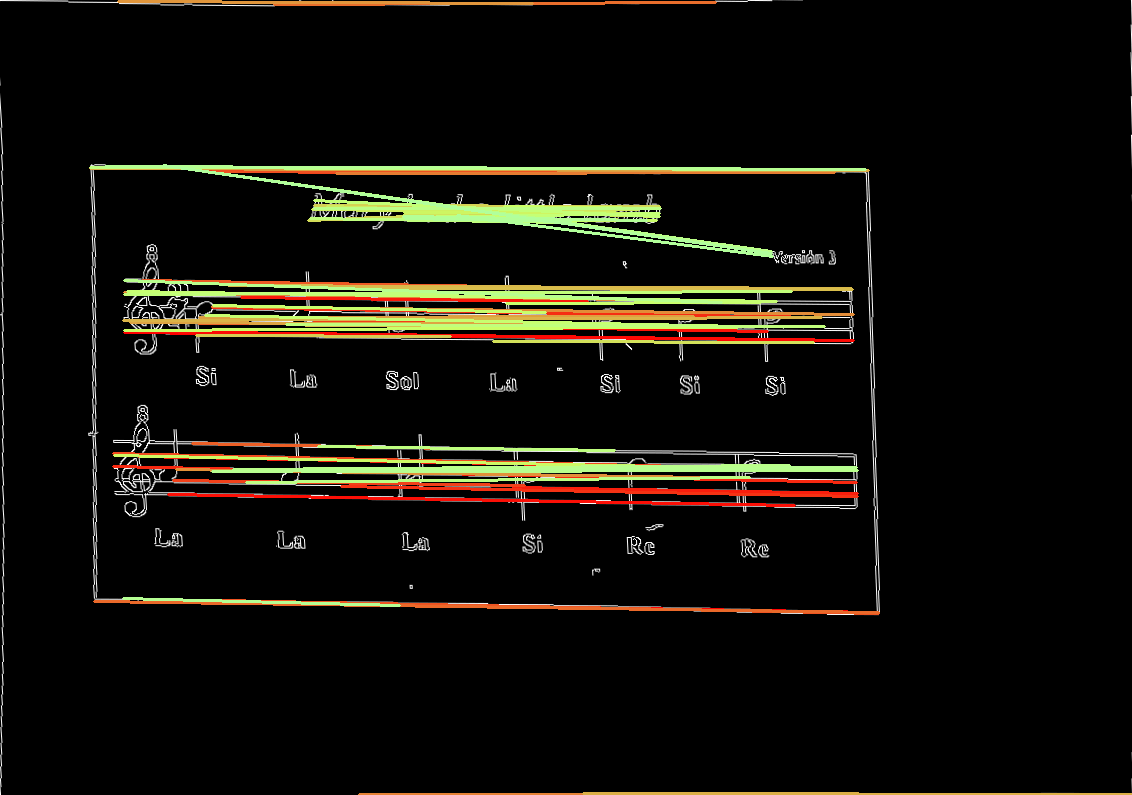

In [ ]:
auxImHoja = r_imHoja.copy()
auxImHoja = cv2.cvtColor(auxImHoja,cv2.COLOR_GRAY2BGR)
i = 0
for linea in arrLineasLargas:
  cv2.line(auxImHoja,(linea.punto1[0],linea.punto1[1]),(linea.punto2[0],linea.punto2[1]),(i*2,i*5,255-i),2)
  i += 1
cv2_imshow(auxImHoja)

In [ ]:
dfPorLongitud.iloc[0]["Angulo"]

In [ ]:
linesH = cv2.HoughLines(r_imHoja,0.7,np.pi/180,100)

In [ ]:
auxImH = r_imHoja.copy()
auxImH = cv2.cvtColor(r_imHoja,cv2.COLOR_GRAY2BGR)
for rho,theta in linesH[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(auxImH,(x1,y1),(x2,y2),(0,0,255),2)

In [ ]:
cv2_imshow(auxImH)

In [ ]:
cv2.imshow("Holo", auxImH) 
#waits for user to press any key  
#(this is necessary to avoid Python kernel form crashing) 
cv2.waitKey(0)  
#closing all open windows  
cv2.destroyAllWindows()

In [ ]:
x_aux = dfPorLongitud["Longitud"]
y_aux = dfPorLongitud["Angulo"]
#plt.plot(x_aux, y_aux, 'o', label = "Plox")
plt.plot(x_aux, y_aux, 'o')
plt.xlabel('Longitud')
plt.ylabel('Angulo')
plt.title('Angulo de las lineas segun longitud')
#plt.legend()
plt.show()

In [ ]:
plt.hist(x_aux)

In [ ]:
plt.hist(y_aux)

In [ ]:
def BinningFreq(arr,n): #Se asume recibe matriz de dos dimensiones (Componente i de una imagen) 
    piv = len(arr)//n
    arrPiv = []
    for i in range(1,n):
        arrPiv.append(i*piv)
    arrPiv.append(len(arr))
    arreglo = []
    bins_aux = []
    previo = 0
    for piv in arrPiv:
        bins_aux = arr[previo:piv]
        arreglo.append(bins_aux)
        previo = piv
    return arreglo

In [ ]:
#def graficarTest(variableValores,nombreVar,errorSuma,errorCant,titulo):
#  plt.plot(variableValores, errorSuma, label = "Error en suma")
#  plt.plot(variableValores, errorCant, label = "Error en número de monedas")
#  plt.xlabel(nombreVar)
#  plt.ylabel('Error')
#  plt.title(titulo)
#  plt.legend()
#  plt.show()

In [ ]:
plt.imshow(r_imIdeal,cmap='gray')

In [ ]:
moda = stats.mode(slopes) #slopes ya no existe, pero es lass pendientesssss
print(moda)

In [ ]:
aux = np.array([np.array([0,0,0,0,0,0,0],dtype=np.uint8),
                np.array([0,0,0,0,0,0,0],dtype=np.uint8),
                np.array([0,0,0,0,0,0,0],dtype=np.uint8),
                np.array([0,0,0,0,0,0,0],dtype=np.uint8),
                np.array([0,0,0,0,0,0,0],dtype=np.uint8),
                np.array([0,0,0,0,0,0,0],dtype=np.uint8),
                np.array([0,0,0,0,0,0,0],dtype=np.uint8)])
aux = cv2.cvtColor(aux,cv2.COLOR_GRAY2RGB)
cv2.line(aux,(0,0),(3,4),(0,0,255))
plt.imshow(aux)

In [ ]:
#https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed 
#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
#sigmaSpace alto podría terminar borrando detalles y no queremos eso porque líneas
#d=3 porque tampoco queremos un blur tan fuerte
imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30)

## Material Bibliográfico

* Adrifersa. *La clave musical* Recuperado de: https://adrifersa.com/teoria-musical/la-clave-musical/ 
* Answers OpenCV ()